In [7]:
# pip install tensorflow

In [9]:
# pip install alpha_vantage

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from alpha_vantage.foreignexchange import ForeignExchange 

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [104]:
api_key = "968U93YONJTBSCFS"   #My Api Key

In [105]:
# Initialize the ForeignExchange class
fx = ForeignExchange(key= "api_key", output_format="pandas")

In [106]:
# Get the daily exchange rates
data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [107]:
# Renaming columns
data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [108]:
data = data.sort_index()

In [109]:
data.head()

,Open,High,Low,Close
date,,,,
2014-11-07,89.70,89.75,89.60,89.70
2014-11-10,89.70,89.75,89.60,89.75
2014-11-11,89.95,89.95,89.95,89.95
2014-11-12,89.95,90.05,89.95,90.00
2014-11-13,90.00,90.15,90.00,90.15


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2558 entries, 2014-11-07 to 2024-08-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2558 non-null   float64
 1   High    2558 non-null   float64
 2   Low     2558 non-null   float64
 3   Close   2558 non-null   float64
dtypes: float64(4)
memory usage: 99.9 KB


In [111]:
# Summary statistics
data.describe()

,Open,High,Low,Close
count,2558.000000,2558.000000,2558.000000,2558.000000
mean,110.412134,110.595684,110.222694,110.428182
std,14.799383,14.830646,14.736880,14.798955
min,89.700000,89.750000,89.600000,89.700000
25%,101.285000,101.400000,101.150000,101.280000
50%,103.500000,103.700000,103.350000,103.500000
75%,114.225000,114.350000,114.087500,114.287500
max,162.980000,163.250000,162.280000,162.980000


In [112]:
df = data.loc['2024':]

In [113]:
df = df["Close"]
df = pd.DataFrame(data=df)

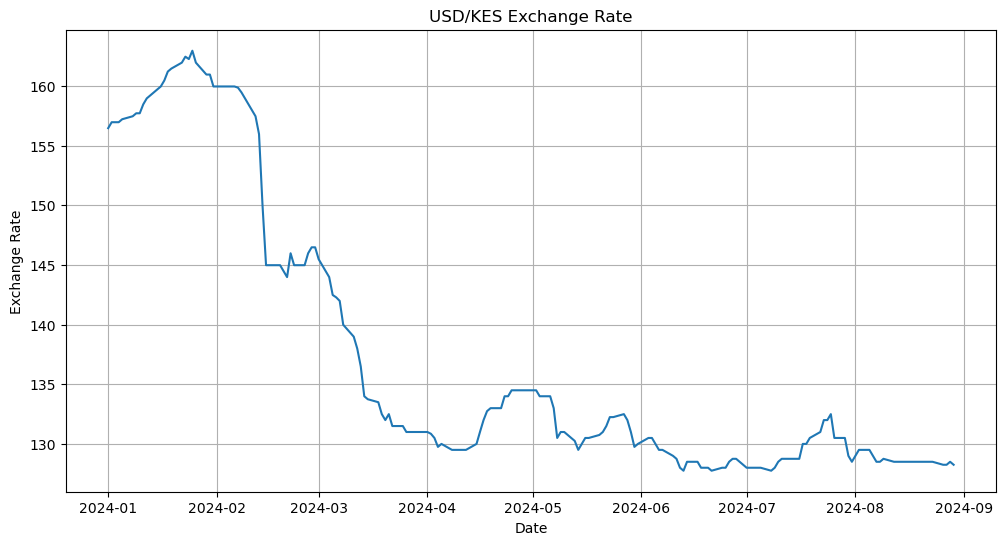

In [114]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [115]:
# Resample the data to include all the days
daily_data = df.resample('D').last()

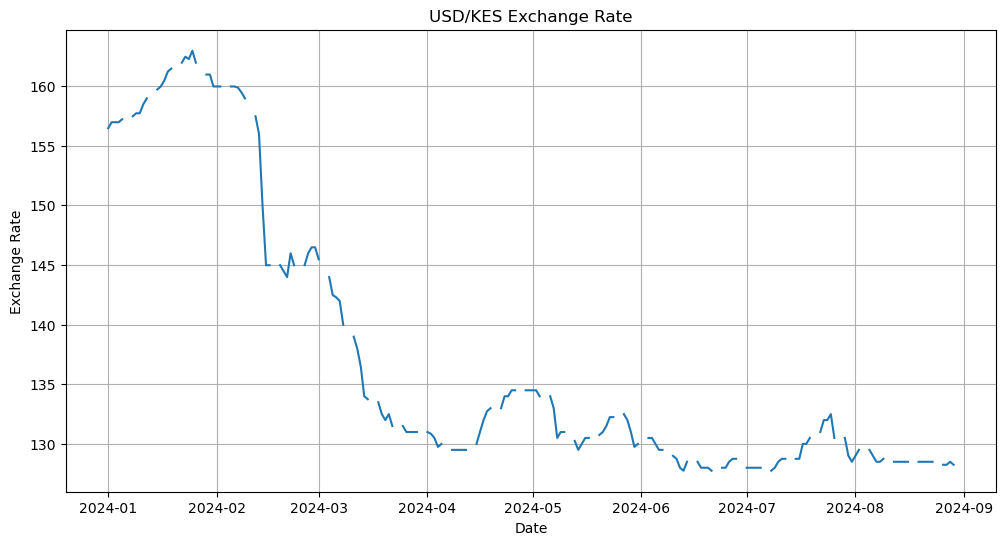

In [116]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [117]:
# interpolate the data to include weekends
filled_data = daily_data.interpolate(method='linear')

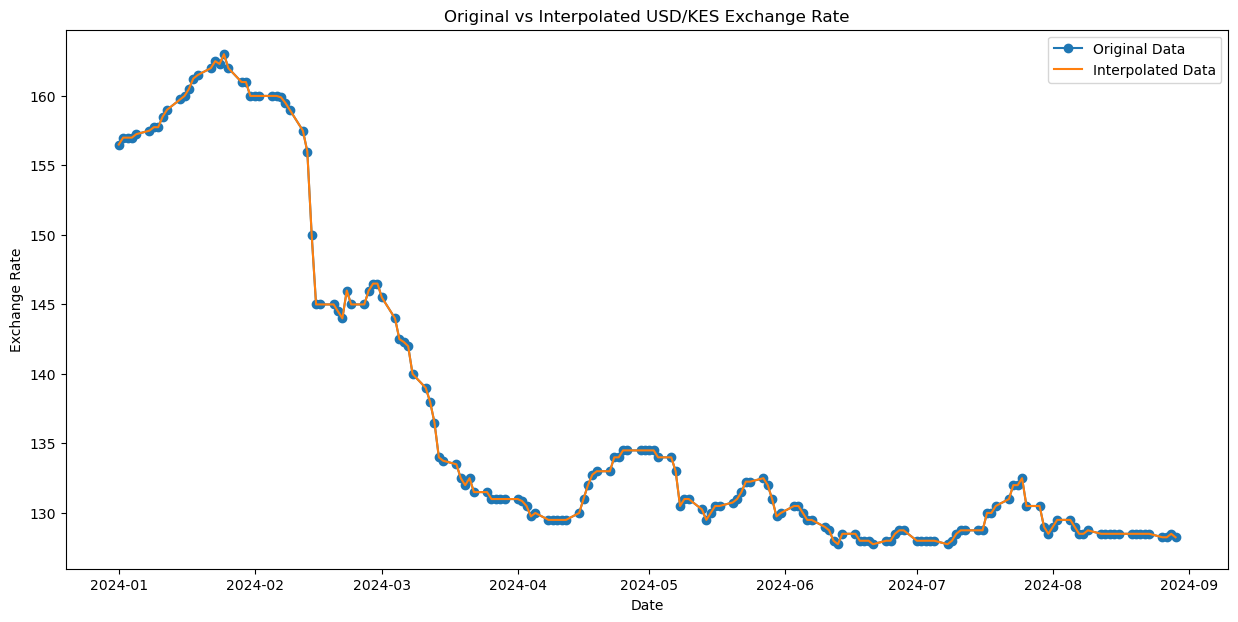

In [118]:
# Plot original vs filled data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], label='Original Data', marker='o')
plt.plot(filled_data.index, filled_data['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Stationarity Check

In [119]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.5864955870439712
p-value: 0.4903736003890151
The series is non-stationary, differencing is required.


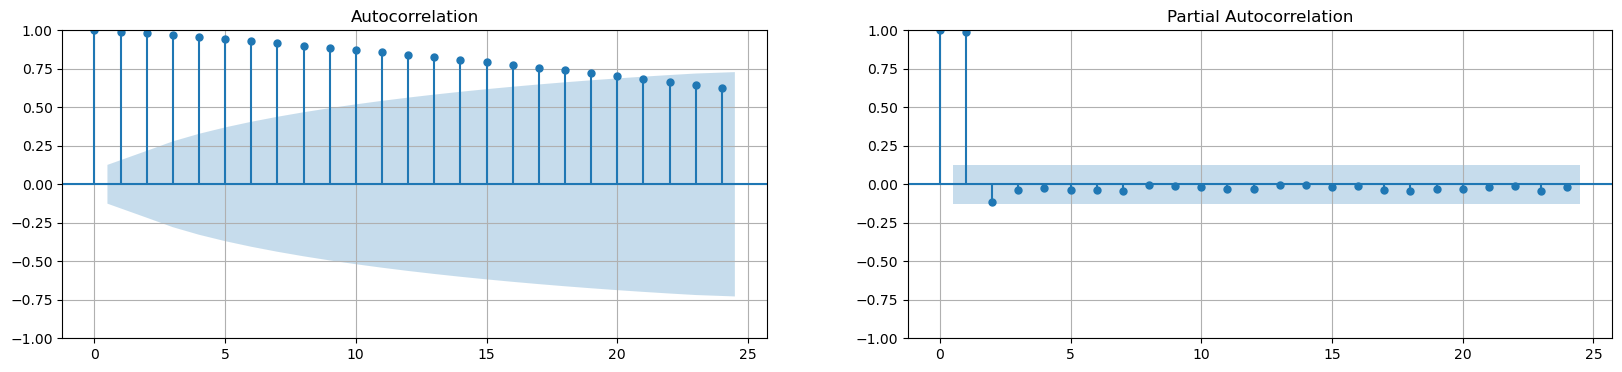

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_data, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_data, ax=axes[1])
axes[1].grid(True)
plt.show()

ACF is not deminishing

#  Prepare data for modeling

## Split the filled data into train and test sets

In [187]:
# Split the filled data into train and test sets
train_size = int(len(filled_data) * 0.95)
train, test = filled_data[:train_size], filled_data[train_size:]

In [188]:
print("Train: ",train.shape)
print("Test : ",test.shape)

Train:  (229, 1)
Test :  (13, 1)


In [189]:
# from pmdarima.arima import auto_arima
# model_auto = auto_arima(filled_data[1:])
# model_auto

In [190]:
# model_auto.summary()

## Decomposition

In [191]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [192]:
add_decomp = seasonal_decompose(train, model="additive")

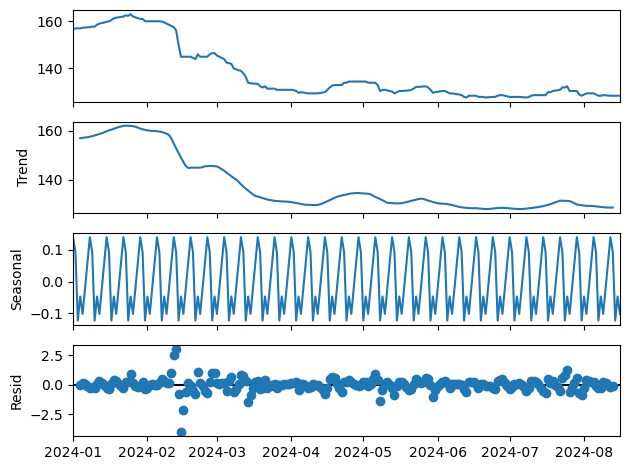

In [193]:
add_decomp.plot()
plt.show()

- there is a trend in the data
- the data is also seasonal
- there is also White noise

## Augmented Dickey-Fuller (ADF) test 

In [194]:
import statsmodels.tsa.stattools as sts


In [195]:
adf_results = sts.adfuller(train)
#adf_results

In [196]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

In [197]:
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.516760599023884
p-value: 0.5252044191952826
Number of Lags Used: 1
Number of Observations Used: 227
Critical Values:
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


Based on the ADF test results, 

- Test statistic: The ADF statistic is higher (less negative) than all the critical values.
- p-value: The p-value is greater than the common significance levels (0.01, 0.05, and 0.10).
- Stationarity: Given that the test statistic is higher than the critical values and the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This suggests that the time series is likely non-stationary.
- Critical values: Since the test statistic is less negative than all these critical values, it supporting the conclusion of non-stationarity.
- Sample size: Is a relatively large sample size, lending reliability to the results.
- Lag selection: 28 lags were used in the test, which helps account for potential autocorrelation in the residuals.

In conclusion, this time series appears to be non-stationary based on the ADF test results. Further differencing or transformation is necessary to achieve stationarity before proceeding with certain time series analyses or models.

# Modeling


## Differencing the Series

In [198]:
diff = train.diff().dropna()

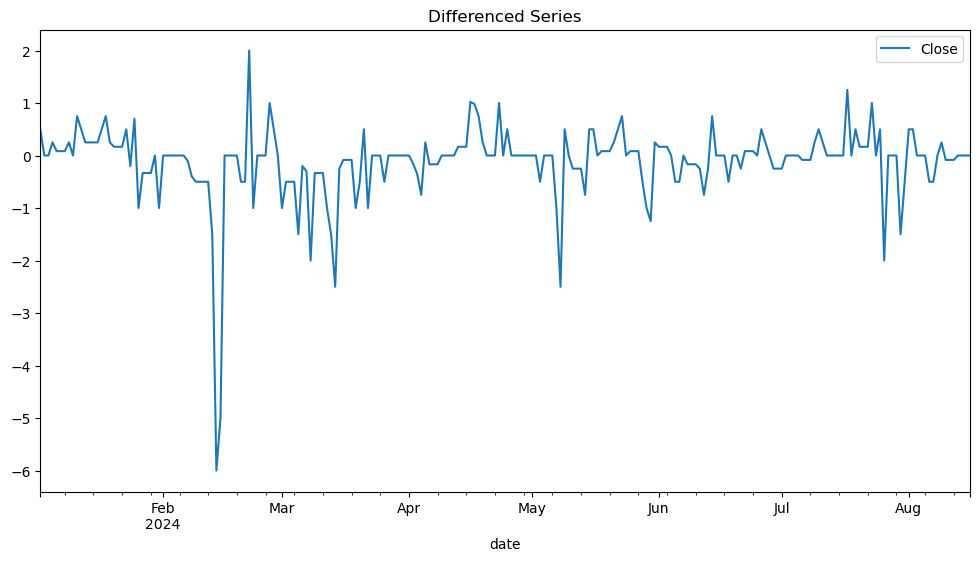

In [199]:
# Plot the differenced series
diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

In [200]:
# Perform the ADF test on the differenced series
adf_result_diff = adfuller(diff)
print('ADF Statistic after Differencing:', adf_result_diff[0])
print('p-value after Differencing:', adf_result_diff[1])
print('Number of Lags Used:', adf_result_diff[2])
print('Number of Observations Used:', adf_result_diff[3])
print('Critical Values after Differencing:', adf_result_diff[4])

ADF Statistic after Differencing: -9.58121740389626
p-value after Differencing: 2.155914653288916e-16
Number of Lags Used: 0
Number of Observations Used: 227
Critical Values after Differencing: {'1%': -3.4594900381360034, '5%': -2.8743581895178485, '10%': -2.573601605503697}


Deductions
- Since the p-value is now lower than 0.005 and the ADF statistic is more negative than the critical values indicate that the time series has become stationary after differencing. 
- Applying one difference (d=1) was sufficient to make the series stationary.

## Proceeding to identify the appropriate values for p and q by analyzing the ACF and PACF plots.

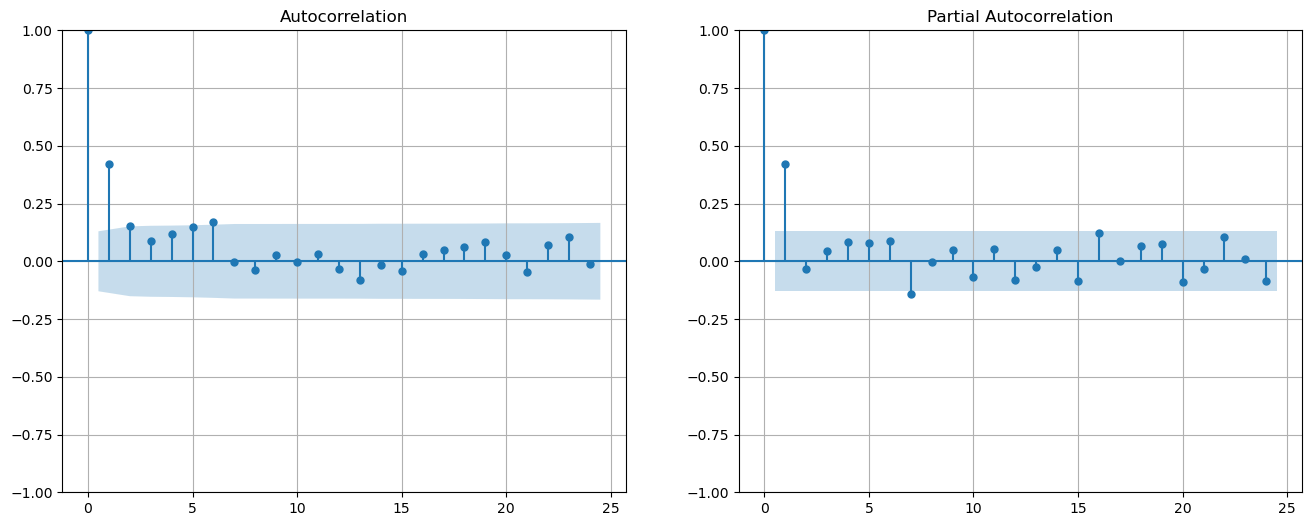

In [201]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff, ax=axes[1])
axes[1].grid(True)
plt.show()

- p = 1
- d = 1
- q = 1
- m = 7

# Model selection

# Method 1

## 1. ARIMA

In [202]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

c:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [203]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -234.245
Date:                Thu, 29 Aug 2024   AIC                            476.490
Time:                        13:33:34   BIC                            490.207
Sample:                    01-01-2024   HQIC                           482.024
                         - 08-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1527      2.702      0.057      0.955      -5.143       5.449
ar.L2          0.1005      1.199      0.084      0.933      -2.250       2.451
ma.L1          0.2973      2.698      0.110      0.9

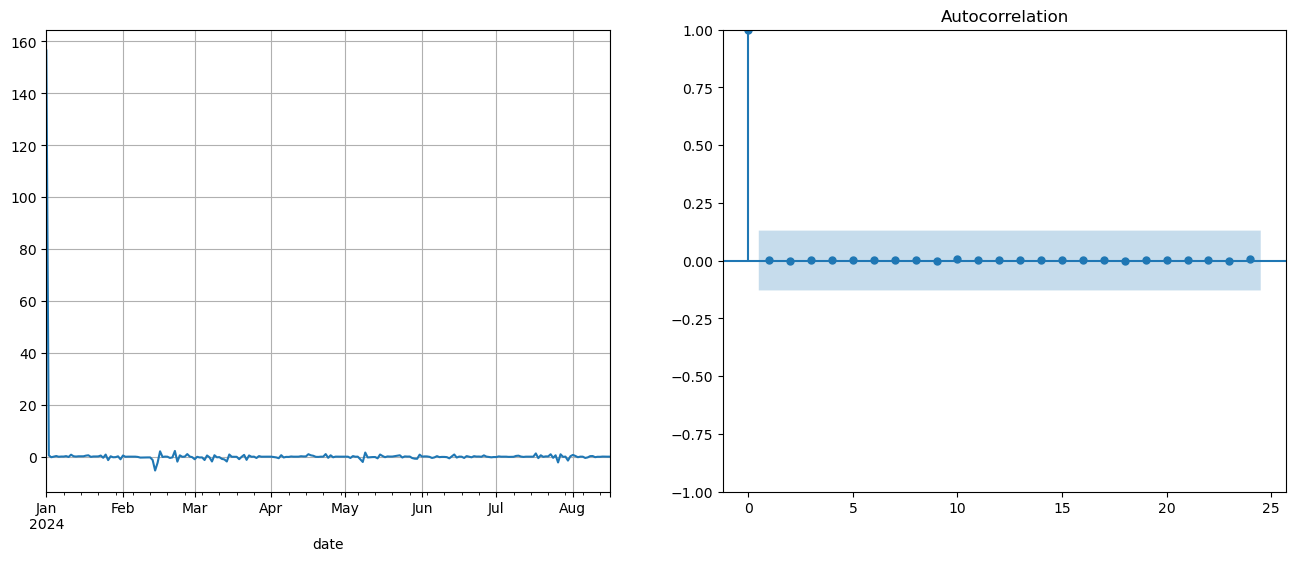

In [204]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot residuals
residuals.plot(ax=axes[0])
axes[0].grid(True)
# Plot ACF of residuals
plot_acf(residuals, ax=axes[1])

plt.show()

In [205]:
predictions = model_fit.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)

In [206]:
predictions

2024-08-17    128.479937
2024-08-18    128.479928
2024-08-19    128.479920
2024-08-20    128.479918
2024-08-21    128.479917
2024-08-22    128.479916
2024-08-23    128.479916
2024-08-24    128.479916
2024-08-25    128.479916
2024-08-26    128.479916
2024-08-27    128.479916
2024-08-28    128.479916
2024-08-29    128.479916
Freq: D, Name: predicted_mean, dtype: float64

In [207]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.01708109959725973


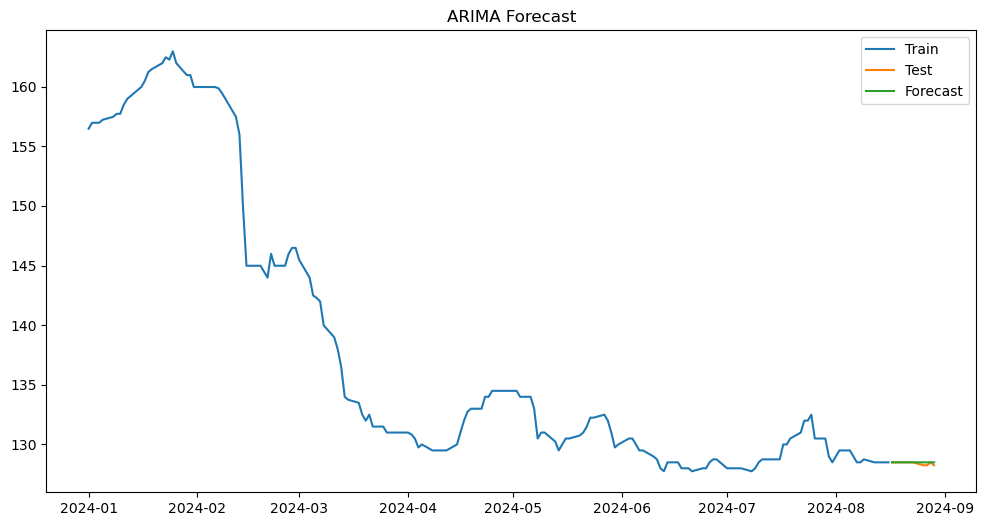

In [208]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## 2. SARIMA


In [209]:
p, d, q = 1, 1, 1

In [210]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted = model_s.fit() 


In [211]:
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -237.714
Date:                           Thu, 29 Aug 2024   AIC                            485.429
Time:                                   13:33:50   BIC                            502.420
Sample:                               01-01-2024   HQIC                           492.289
                                    - 08-16-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3663      0.101      3.644      0.000       0.169       0.563
ma.L1          0.0956      0.133      0.717

In [212]:
from sklearn.metrics import mean_squared_error

# Get the predicted values
predictions2 = fitted.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)


In [213]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.47641265340687805


In [214]:
predictions2

2024-08-17    128.533849
2024-08-18    128.528449
2024-08-19    128.506544
2024-08-20    128.342640
2024-08-21    127.989547
2024-08-22    127.933271
2024-08-23    127.745656
2024-08-24    127.695498
2024-08-25    127.649964
2024-08-26    127.610942
2024-08-27    127.454456
2024-08-28    127.125599
2024-08-29    127.072836
Freq: D, Name: predicted_mean, dtype: float64

In [215]:
test.tail()

,Close
date,
2024-08-25,128.313333
2024-08-26,128.230000
2024-08-27,128.230000
2024-08-28,128.480000
2024-08-29,128.230000


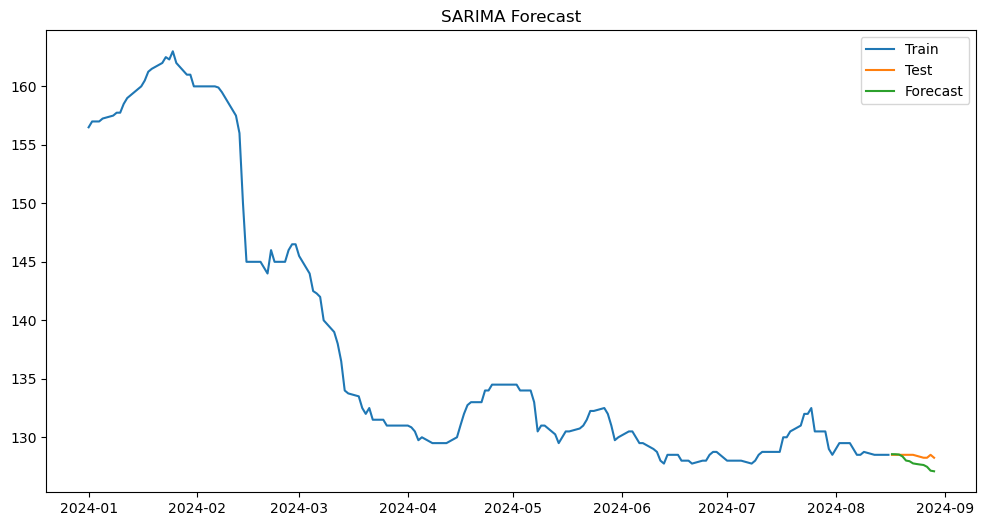

In [216]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## 3. LSTM Model

In [225]:
# Ensure 'Close' is a numpy array of the right shape
data = data[['Close']].values

In [226]:
data

array([[ 89.7 ],
       [ 89.75],
       [ 89.95],
       ...,
       [128.23],
       [128.48],
       [128.23]])

In [227]:
# Step 3: Data Preprocessing
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [228]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [229]:
# Define time step for the sequences
time_step = 60

In [230]:
# Create sequences
X, y = create_sequences(scaled_data, time_step)

In [231]:
# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [232]:
# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [233]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (1998, 60, 1)
X_test shape is.... (500, 60, 1)
y_train shape is... (1998,)
y_test shape is.... (500,)


In [234]:
# Step 4: Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [235]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [236]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0112 - val_loss: 0.0029
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.7903e-05 - val_loss: 0.0013
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.5827e-05 - val_loss: 0.0015
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.6823e-05 - val_loss: 0.0014
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.3400e-05 - val_loss: 0.0014
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.1121e-05 - val_loss: 0.0013
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7433e-05 - val_loss: 0.0012
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.8976e-05 - val_loss: 0.0015
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6513e-05 - val_loss: 0.0015
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.6065e-05 - val_loss: 0.0014
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.0712e-05 - val_loss: 0.0013
Epoch 12/20
63/63 ━━━━━

In [237]:
# Step 5: Make Predictions
predicted = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [238]:
# Inverse transform the predictions to original scale
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

In [239]:
# predicted

In [240]:
# Inverse transform the actual values for comparison
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

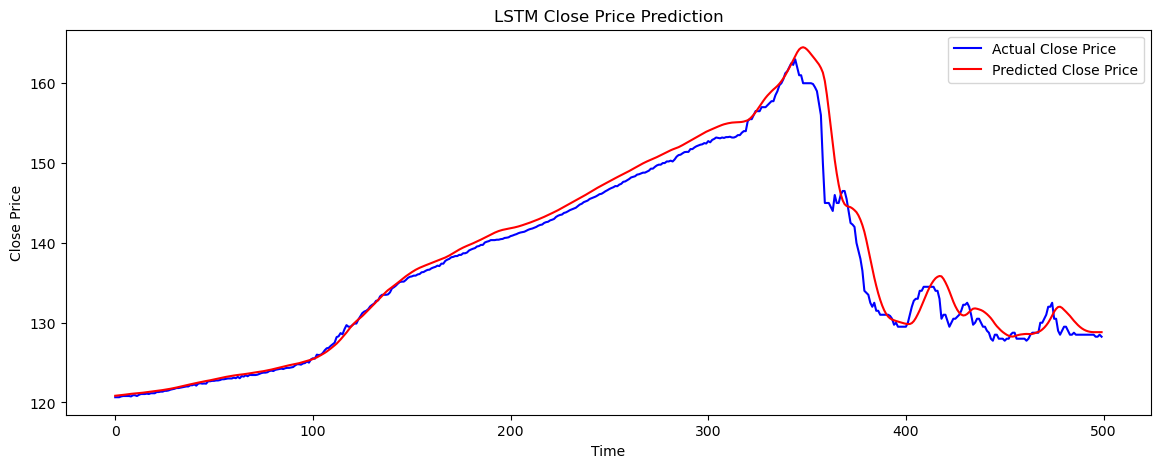

In [241]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(predicted, color='red', label='Predicted Close Price')
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Method2

## 1. ARIMA Model

In [217]:
# Function to calculate RMSE
def calculate_rmse(train, predicted):
    return sqrt(mean_squared_error(train, predicted))

In [218]:
# Step 4: ARIMA Model
def fit_arima(train, test):
    model = ARIMA(train, order=(1, 1, 1))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test['Close'], forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'ARIMA RMSE: {rmse}')

Running ARIMA model...


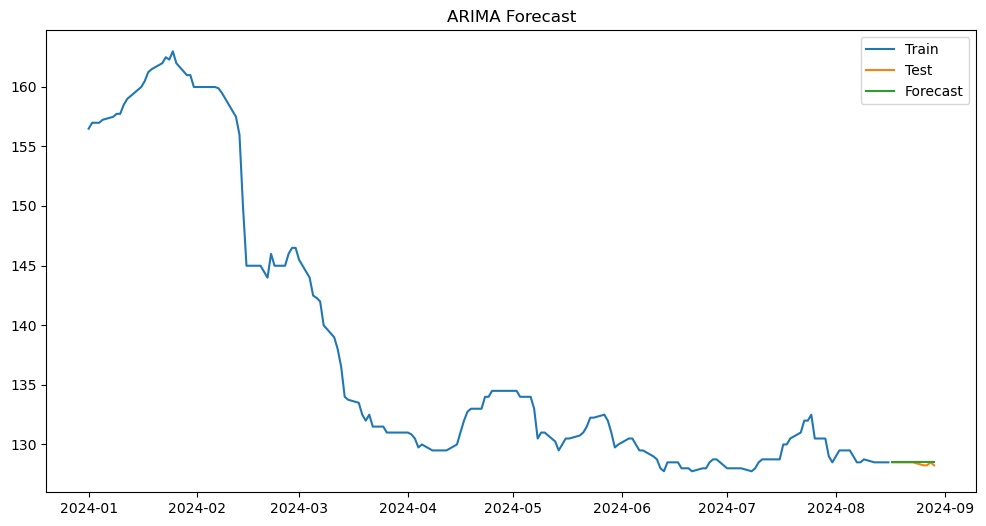

ARIMA RMSE: 0.13074350681654032


In [219]:
# Step 7: Run the models
print("Running ARIMA model...")
fit_arima(train, test)

## 2. SARIMA Model

In [220]:

# Step 5: SARIMA Model
def fit_sarima(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test, forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('SARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'SARIMA RMSE: {rmse}')

Running SARIMA model...


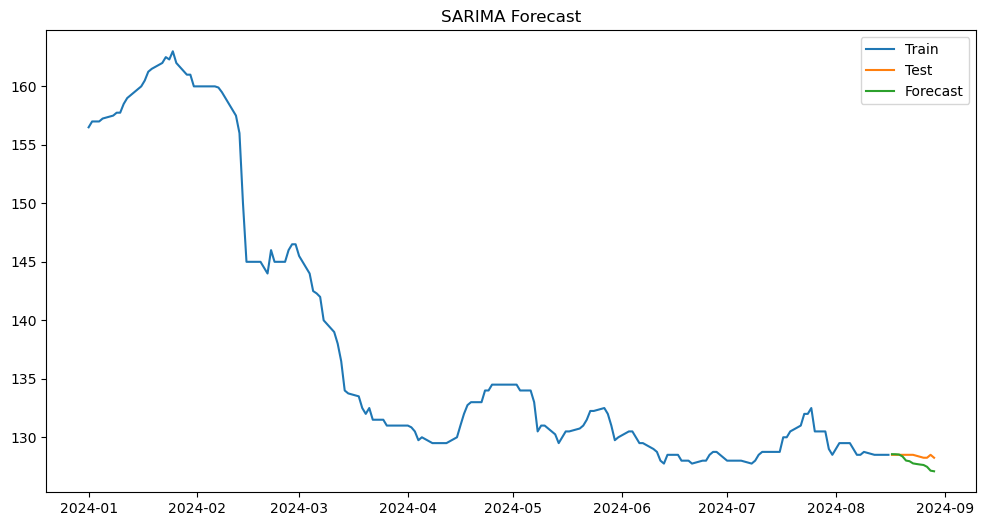

SARIMA RMSE: 0.6902265232565886


In [221]:
print("Running SARIMA model...")
fit_sarima(train, test)

## 3. LSTM

# USD TO UGX

In [152]:
# Get the daily exchange rates
data2, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="UGX", outputsize="full")

In [153]:
# Renaming columns
data2.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [154]:
data2 = data2.sort_index()

In [155]:
df2 = data2.loc['2024':]

In [156]:
df2.head()

,Open,High,Low,Close
date,,,,
2024-01-01,3777.2,3777.2,3777.2,3777.2
2024-01-02,3777.2,3777.2,3776.8,3776.8
2024-01-03,3776.8,3801.8,3776.8,3801.8
2024-01-04,3801.8,3801.8,3797.5,3797.5
2024-01-05,3797.5,3797.5,3787.4,3787.4


In [157]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173 entries, 2024-01-01 to 2024-08-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    173 non-null    float64
 1   High    173 non-null    float64
 2   Low     173 non-null    float64
 3   Close   173 non-null    float64
dtypes: float64(4)
memory usage: 6.8 KB


In [159]:
df2 = df2["Close"]
df2 = pd.DataFrame(data=df2)

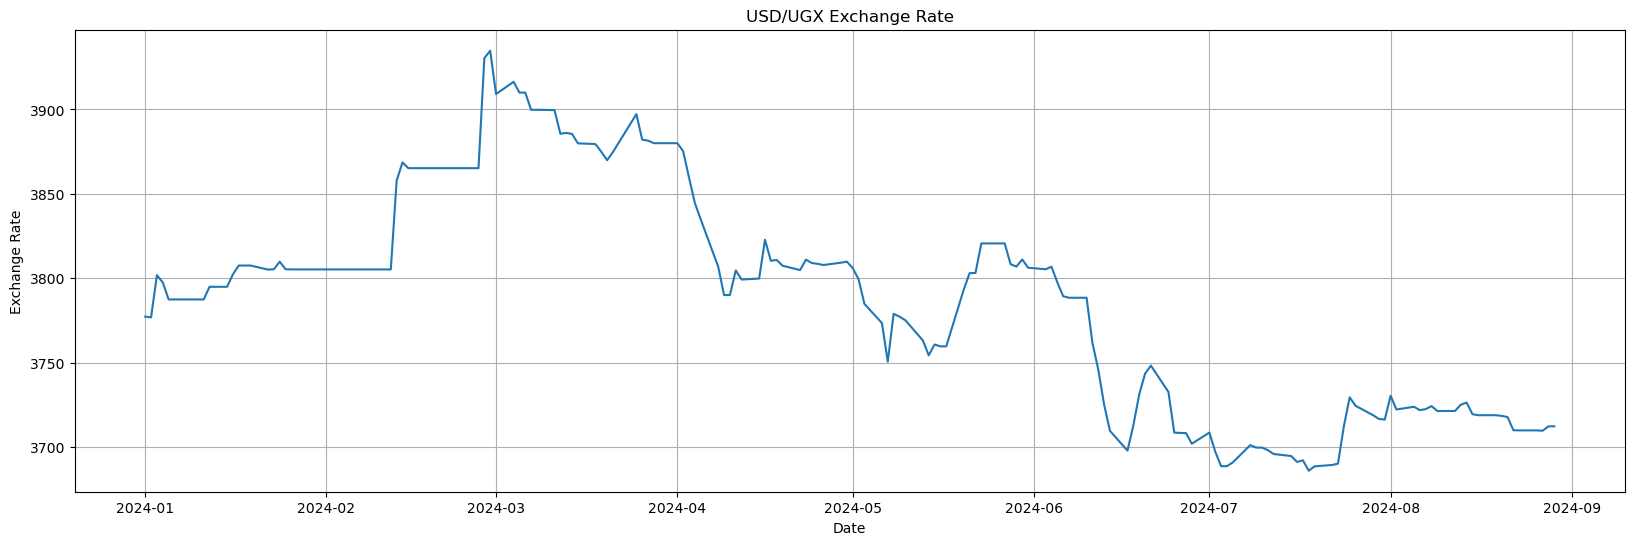

In [160]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df2['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [161]:
# Resample the data to include all the days
daily_df = df2.resample('D').last()

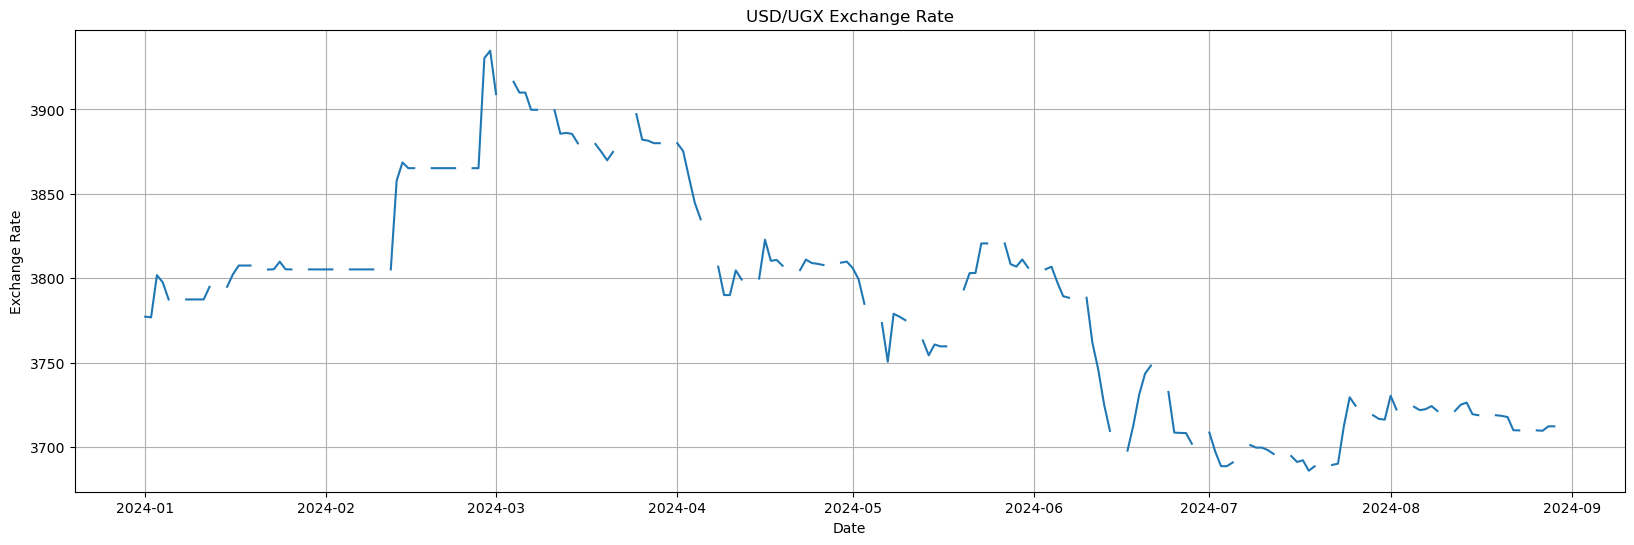

In [162]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_df['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [163]:
# interpolate the data to include weekends
filled_df = daily_df.interpolate(method='linear')

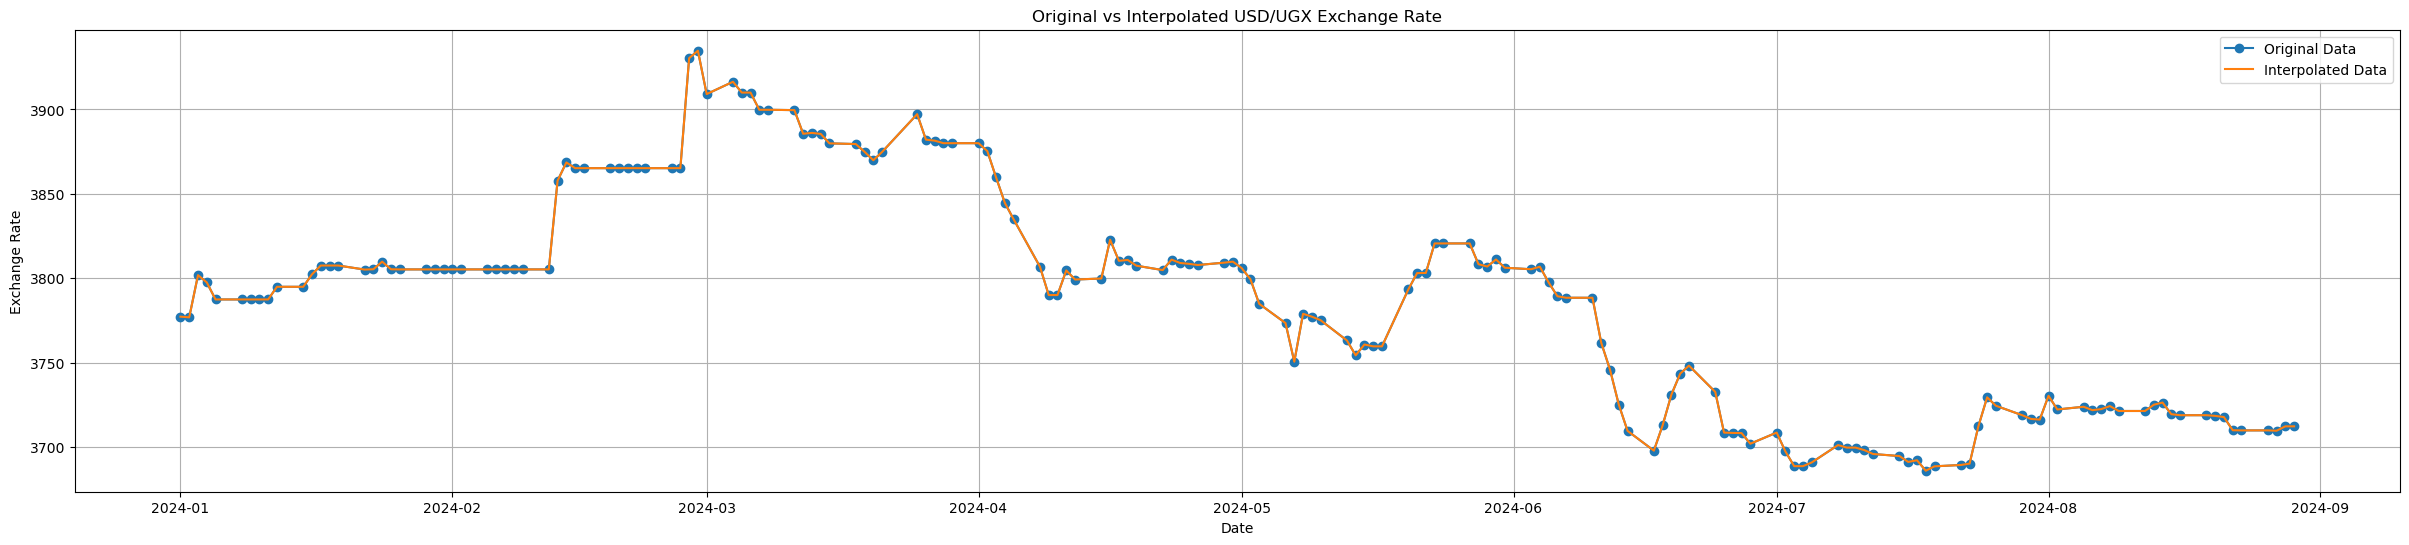

In [164]:
# Plot original vs filled data
plt.figure(figsize=(30, 6))
plt.plot(df2.index, df2['Close'], label='Original Data', marker='o')
plt.plot(filled_df.index, filled_df['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.legend()
plt.show()

In [165]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_df['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.0127728013368775
p-value: 0.7485772549424587
The series is non-stationary, differencing is required.


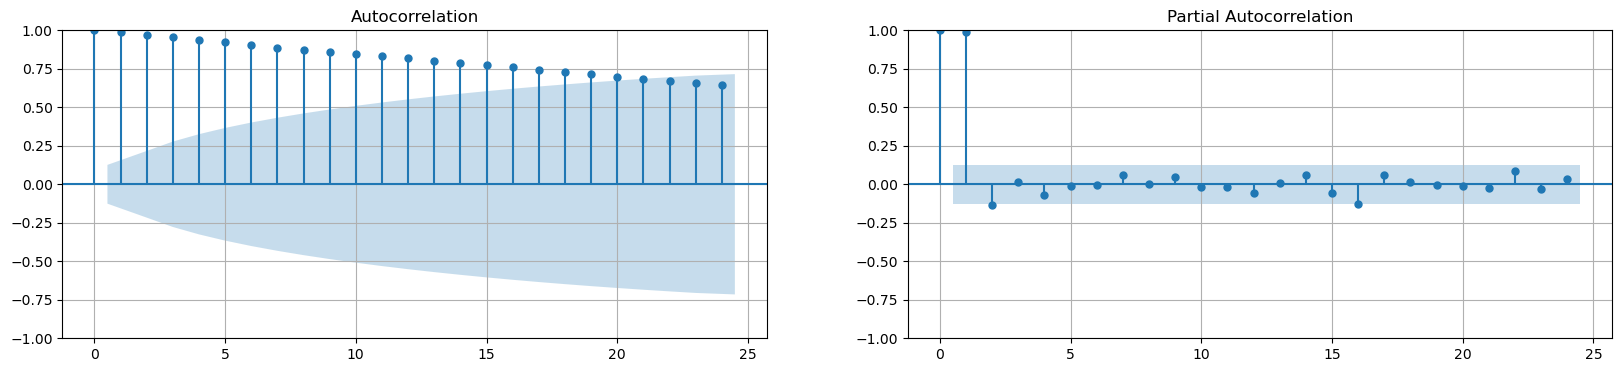

In [166]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_df, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_df, ax=axes[1])
axes[1].grid(True)
plt.show()

In [167]:
# Split the filled data into train and test sets
train_size2 = int(len(filled_df) * 0.95)
train2, test2 = filled_df[:train_size2], filled_df[train_size2:]

In [168]:
print("Train: ",train2.shape)
print("Test : ",test2.shape)

Train:  (229, 1)
Test :  (13, 1)


In [169]:
add_decomp2 = seasonal_decompose(train2, model="additive")

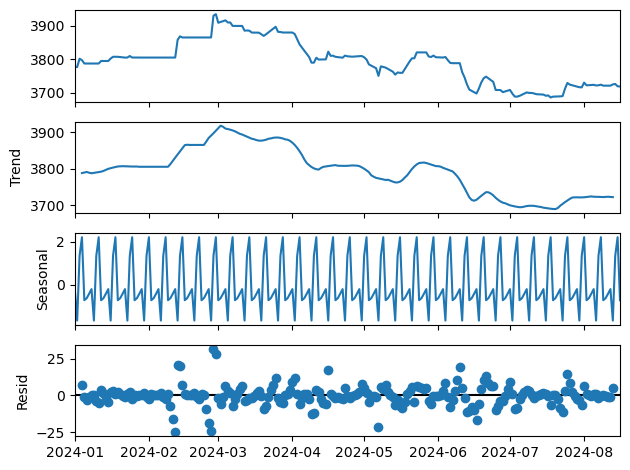

In [170]:
add_decomp2.plot()
plt.show()

In [171]:
import statsmodels.tsa.stattools as sts
adf_results2 = sts.adfuller(train2)
#adf_results

In [172]:
adf_statistic = adf_results2[0]
p_value = adf_results2[1]
usedlag = adf_results2[2]
nobs = adf_results2[3]
critical_values = adf_results2[4]
icbest = adf_results2[5]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')


ADF Statistic: -1.04434445935217
p-value: 0.7367492119520364
Number of Lags Used: 1
Number of Observations Used: 227
Critical Values:
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


In [173]:
diff2 = train2.diff().dropna()

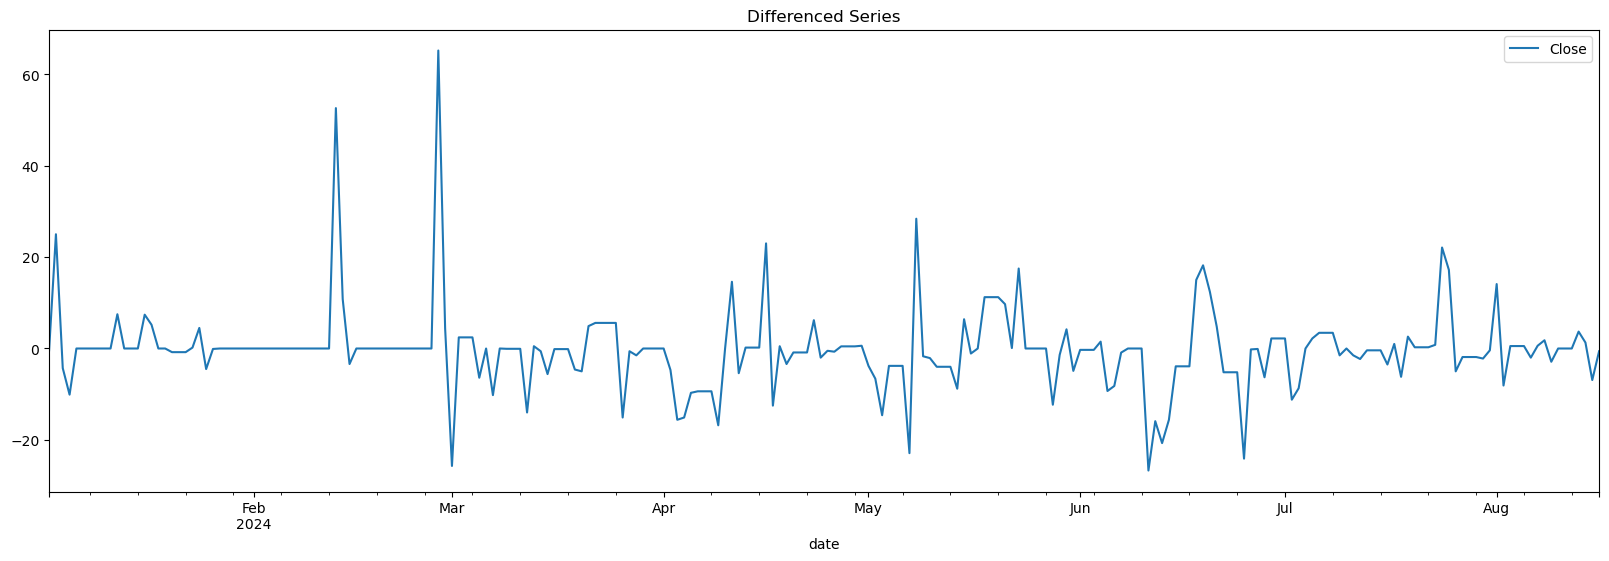

In [174]:
# Plot the differenced series
diff2.plot(figsize=(20, 6))
plt.title('Differenced Series')
plt.show()

In [175]:
# Perform the ADF test on the differenced series
adf_result_diff2 = adfuller(diff2)
print('ADF Statistic after Differencing:', adf_result_diff2[0])
print('p-value after Differencing:', adf_result_diff2[1])
print('Number of Lags Used:', adf_result_diff2[2])
print('Number of Observations Used:', adf_result_diff2[3])
print('Critical Values after Differencing:', adf_result_diff2[4])

ADF Statistic after Differencing: -12.646771975874824
p-value after Differencing: 1.3962125565032825e-23
Number of Lags Used: 0
Number of Observations Used: 227
Critical Values after Differencing: {'1%': -3.4594900381360034, '5%': -2.8743581895178485, '10%': -2.573601605503697}


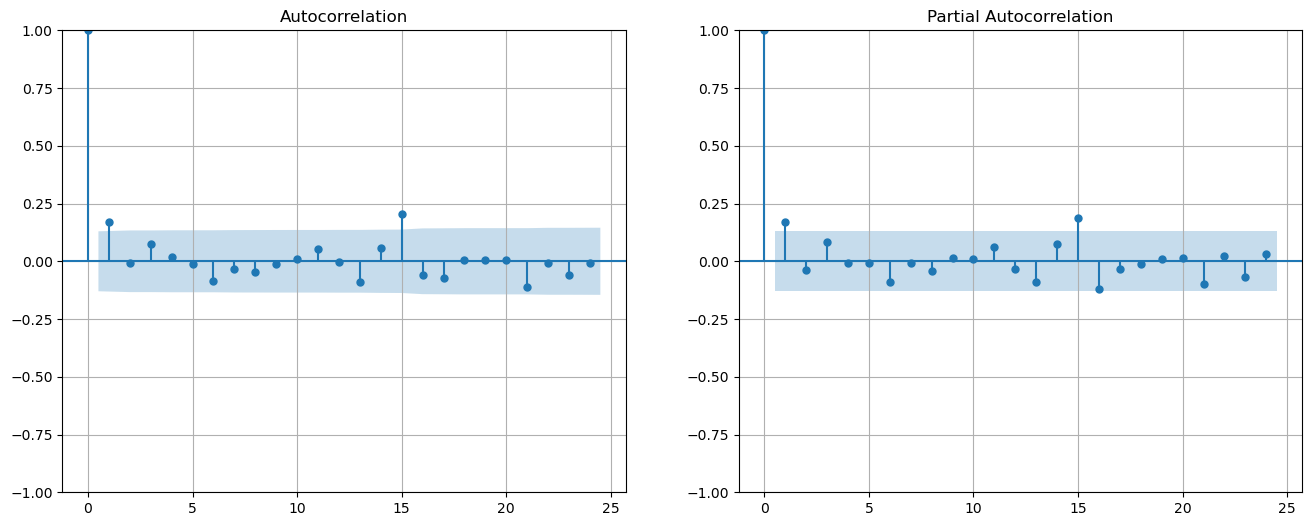

In [176]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff2, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff2, ax=axes[1])
axes[1].grid(True)
plt.show()

In [177]:
# Replace p, d, q with the values identified from ACF and PACF
model2 = ARIMA(train2, order=(5, 1, 1))
model_fit2 = model2.fit()

In [178]:
predict = model_fit2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [179]:
predict

2024-08-17    3719.147189
2024-08-18    3718.622364
2024-08-19    3718.520862
2024-08-20    3718.564318
2024-08-21    3718.528085
2024-08-22    3718.515286
2024-08-23    3718.519493
2024-08-24    3718.517318
2024-08-25    3718.515927
2024-08-26    3718.516268
2024-08-27    3718.516169
2024-08-28    3718.516033
2024-08-29    3718.516056
Freq: D, Name: predicted_mean, dtype: float64

In [180]:
# Calculate Mean Squared Error
mse2 = mean_squared_error(test2, predict)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 41.416206213846934


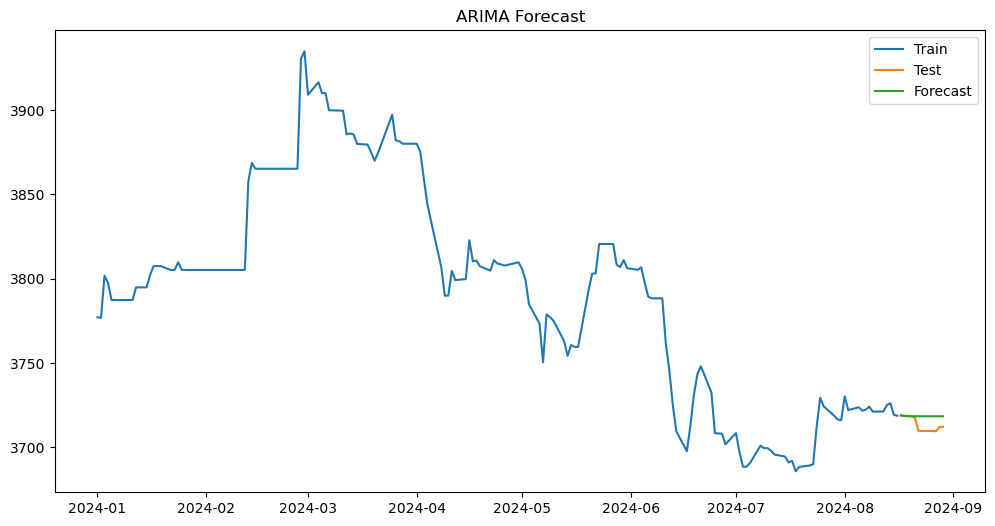

In [181]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [182]:
p,d,q = 1,1,1

In [183]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s2 = SARIMAX(train2, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted2 = model_s2.fit() 


In [184]:
# Get the predicted values
predict2 = fitted2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [185]:
predict2

2024-08-17    3719.549732
2024-08-18    3719.168099
2024-08-19    3719.059869
2024-08-20    3717.090022
2024-08-21    3720.507262
2024-08-22    3720.699267
2024-08-23    3717.572780
2024-08-24    3717.438261
2024-08-25    3717.314661
2024-08-26    3717.137756
2024-08-27    3715.329363
2024-08-28    3718.688080
2024-08-29    3718.705456
Freq: D, Name: predicted_mean, dtype: float64

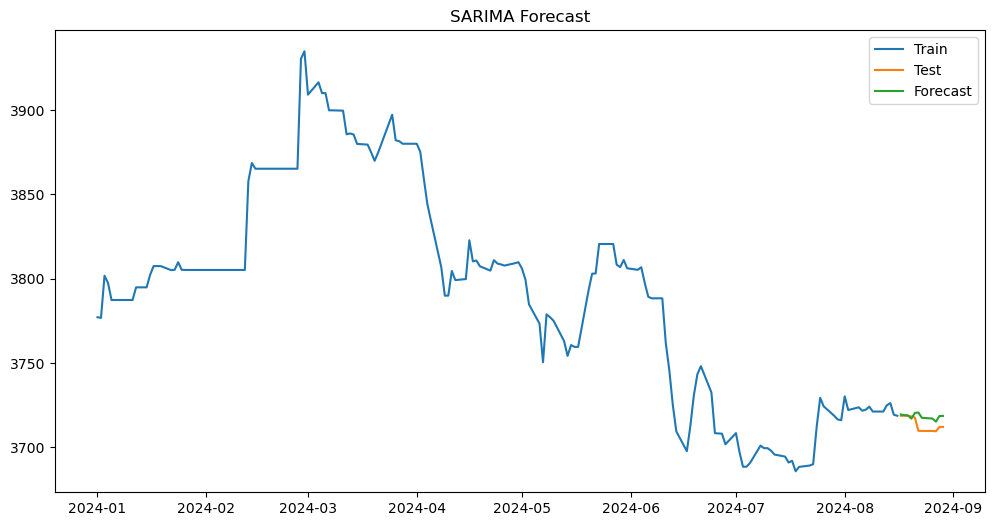

In [186]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [242]:
# Ensure 'Close' is a numpy array of the right shape
data2 = data2[['Close']].values

In [243]:
data2

array([[2705. ],
       [2700. ],
       [2710. ],
       ...,
       [3709.6],
       [3712.2],
       [3712.2]])

In [244]:
# Step 3: Data Preprocessing
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data2)

In [245]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data2, time_step=60):
    X, y = [], []
    for i in range(len(data2) - time_step):
        X.append(data2[i:i + time_step, 0])
        y.append(data2[i + time_step, 0])
    return np.array(X), np.array(y)

In [246]:
# Define time step for the sequences
time_step = 60

In [247]:
# Create sequences
X, y = create_sequences(scaled_data, time_step)

In [248]:
# X

In [249]:
# y

In [250]:


# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [251]:

# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [252]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (1996, 60, 1)
X_test shape is.... (500, 60, 1)
y_train shape is... (1996,)
y_test shape is.... (500,)


In [253]:
# Step 4: Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [254]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [255]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0968 - val_loss: 0.0017
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 7.9368e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.8810e-04 - val_loss: 4.9668e-04
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.7143e-04 - val_loss: 4.8722e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.1947e-04 - val_loss: 4.7490e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.0314e-04 - val_loss: 5.5068e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.0148e-04 - val_loss: 4.7995e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.9136e-04 - val_loss: 4.4410e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.3315e-04 - val_loss: 4.3315e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.4805e-04 - val_loss: 5.3583e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.1617e-04 - val_loss

In [256]:
# Step 5: Make Predictions
predicted = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [257]:
# Inverse transform the predictions to original scale
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

In [258]:
# predicted

In [259]:
# Inverse transform the actual values for comparison
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

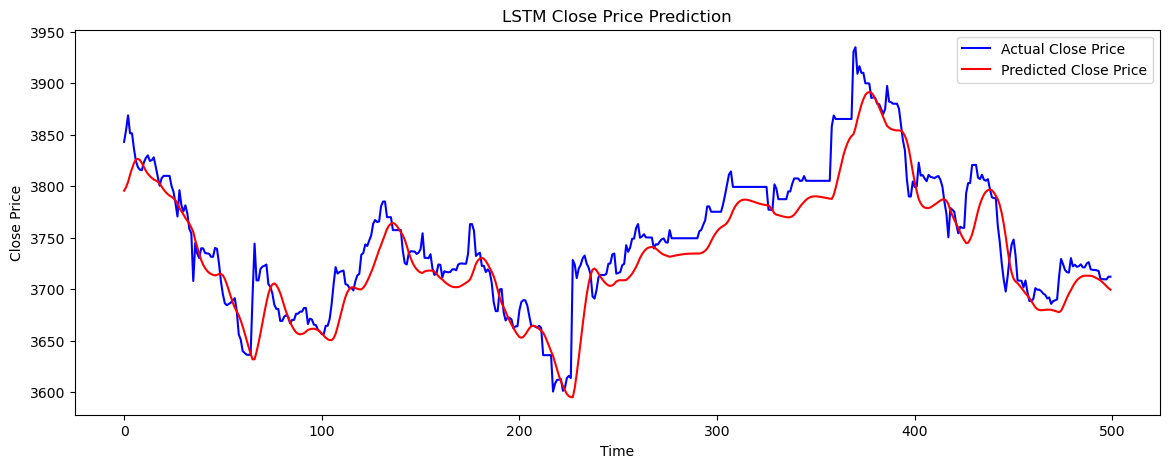

In [260]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(predicted, color='red', label='Predicted Close Price')
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [100]:
# Step 1: Prepare the latest data sequence for making future predictions
last_sequence = scaled_data[-time_step:]  # Extract the last 60 days (or time_step) values
last_sequence = last_sequence.reshape((1, time_step, 1))  # Reshape to the format LSTM expects

In [101]:

# Step 2: Predict the next 30 days iteratively
future_predictions = []

for _ in range(30):  # Predict for the next 30 days
    # Predict the next value
    next_value = model.predict(last_sequence)[0][0]
    
    # Append the predicted value to future_predictions
    future_predictions.append(next_value)
    
    # Update the sequence: Remove the first value and add the predicted value
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_value]], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [83]:


# Step 3: Inverse transform the predicted values to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [84]:

# Step 4: Create date range for the next 30 days
# Assuming 'data' has a DateTime index, extend it for the next 30 days
last_date = data.index[-1]  # Get the last date from the current data
future_dates = pd.date_range(last_date, periods=30, freq='D')  # Generate future dates


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [85]:

# Plot the predictions for the next 30 days
plt.figure(figsize=(14, 5))
plt.plot(future_dates, future_predictions, color='green', label='Predicted Close Price (Next 30 Days)')
plt.title('LSTM Future Predictions for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

NameError: name 'future_dates' is not defined

<Figure size 1400x500 with 0 Axes>